> Train 
  - input_train.csv
  - output_train.csv

> Test
  - input_test.csv 
  - output_test.csv 

input: 5 dimension input data 
output: 0,1 binary classification 

Q: predict output & calculate test acc, recall, precision

Q. Explain the dataset & how i solved the problem 

In [173]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [174]:
import pandas as pd 
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')


#resample 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

#model 


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn import svm
from sklearn.linear_model import SGDClassifier , LogisticRegression , RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV ,train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
 

In [175]:
x_train = pd.read_csv('/content/drive/MyDrive/dev/data/input_train.csv', header=None)
train_y = pd.read_csv('/content/drive/MyDrive/dev/data/output_train.csv',header = None )

x_test = pd.read_csv('/content/drive/MyDrive/dev/data/input_test.csv', header = None )
test_y = pd.read_csv('/content/drive/MyDrive/dev/data/output_test.csv',header = None )

print('train')
print(x_train.shape)
print(train_y.shape)

print('test')
print(x_test.shape)
print(test_y.shape)

train
(10000, 10)
(1, 10000)
test
(4000, 10)
(1, 4000)


In [176]:
#check x variables -> 5dim *2 spreadout 
x_train.head()
x_train.describe()

,0,1,2,3,4,5,6,7,8,9
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.616695,1.838899,1.356889,-0.447446,-0.102193,0.824274,0.426026,0.909038,0.933762,0.764410
std,2.952271,1.698344,2.227881,2.907089,2.189128,2.168234,2.237067,0.766572,3.066598,0.853795
min,-10.909000,-5.873000,-8.025800,-13.089000,-7.981500,-7.597300,-7.832500,-3.049500,-10.848000,-5.334100
25%,-1.231200,0.754875,-0.089810,-2.370375,-1.597275,-0.609405,-1.075175,0.642420,-1.185000,0.357542
50%,0.506795,1.865600,1.402400,-0.422140,-0.102800,0.809840,0.443370,1.037050,0.759325,0.829125
75%,2.450100,2.978125,2.853600,1.514950,1.353575,2.299875,1.939825,1.384525,3.036750,1.285225
max,11.801000,9.640900,9.958900,12.366000,8.509800,8.364000,9.497500,2.921100,12.540000,4.316500


0    9000
1    1000
Name: y, dtype: int64

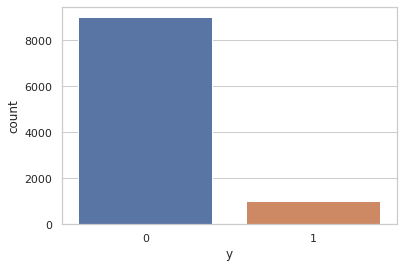

In [177]:
#recreate y column 
train_y= train_y.transpose()
test_y= test_y.transpose()
train_y.columns = ['y']
test_y.columns = ['y'] 

sns.countplot(train_y['y'])  #the data is unbalanced to the 0 
train_y['y'].value_counts()

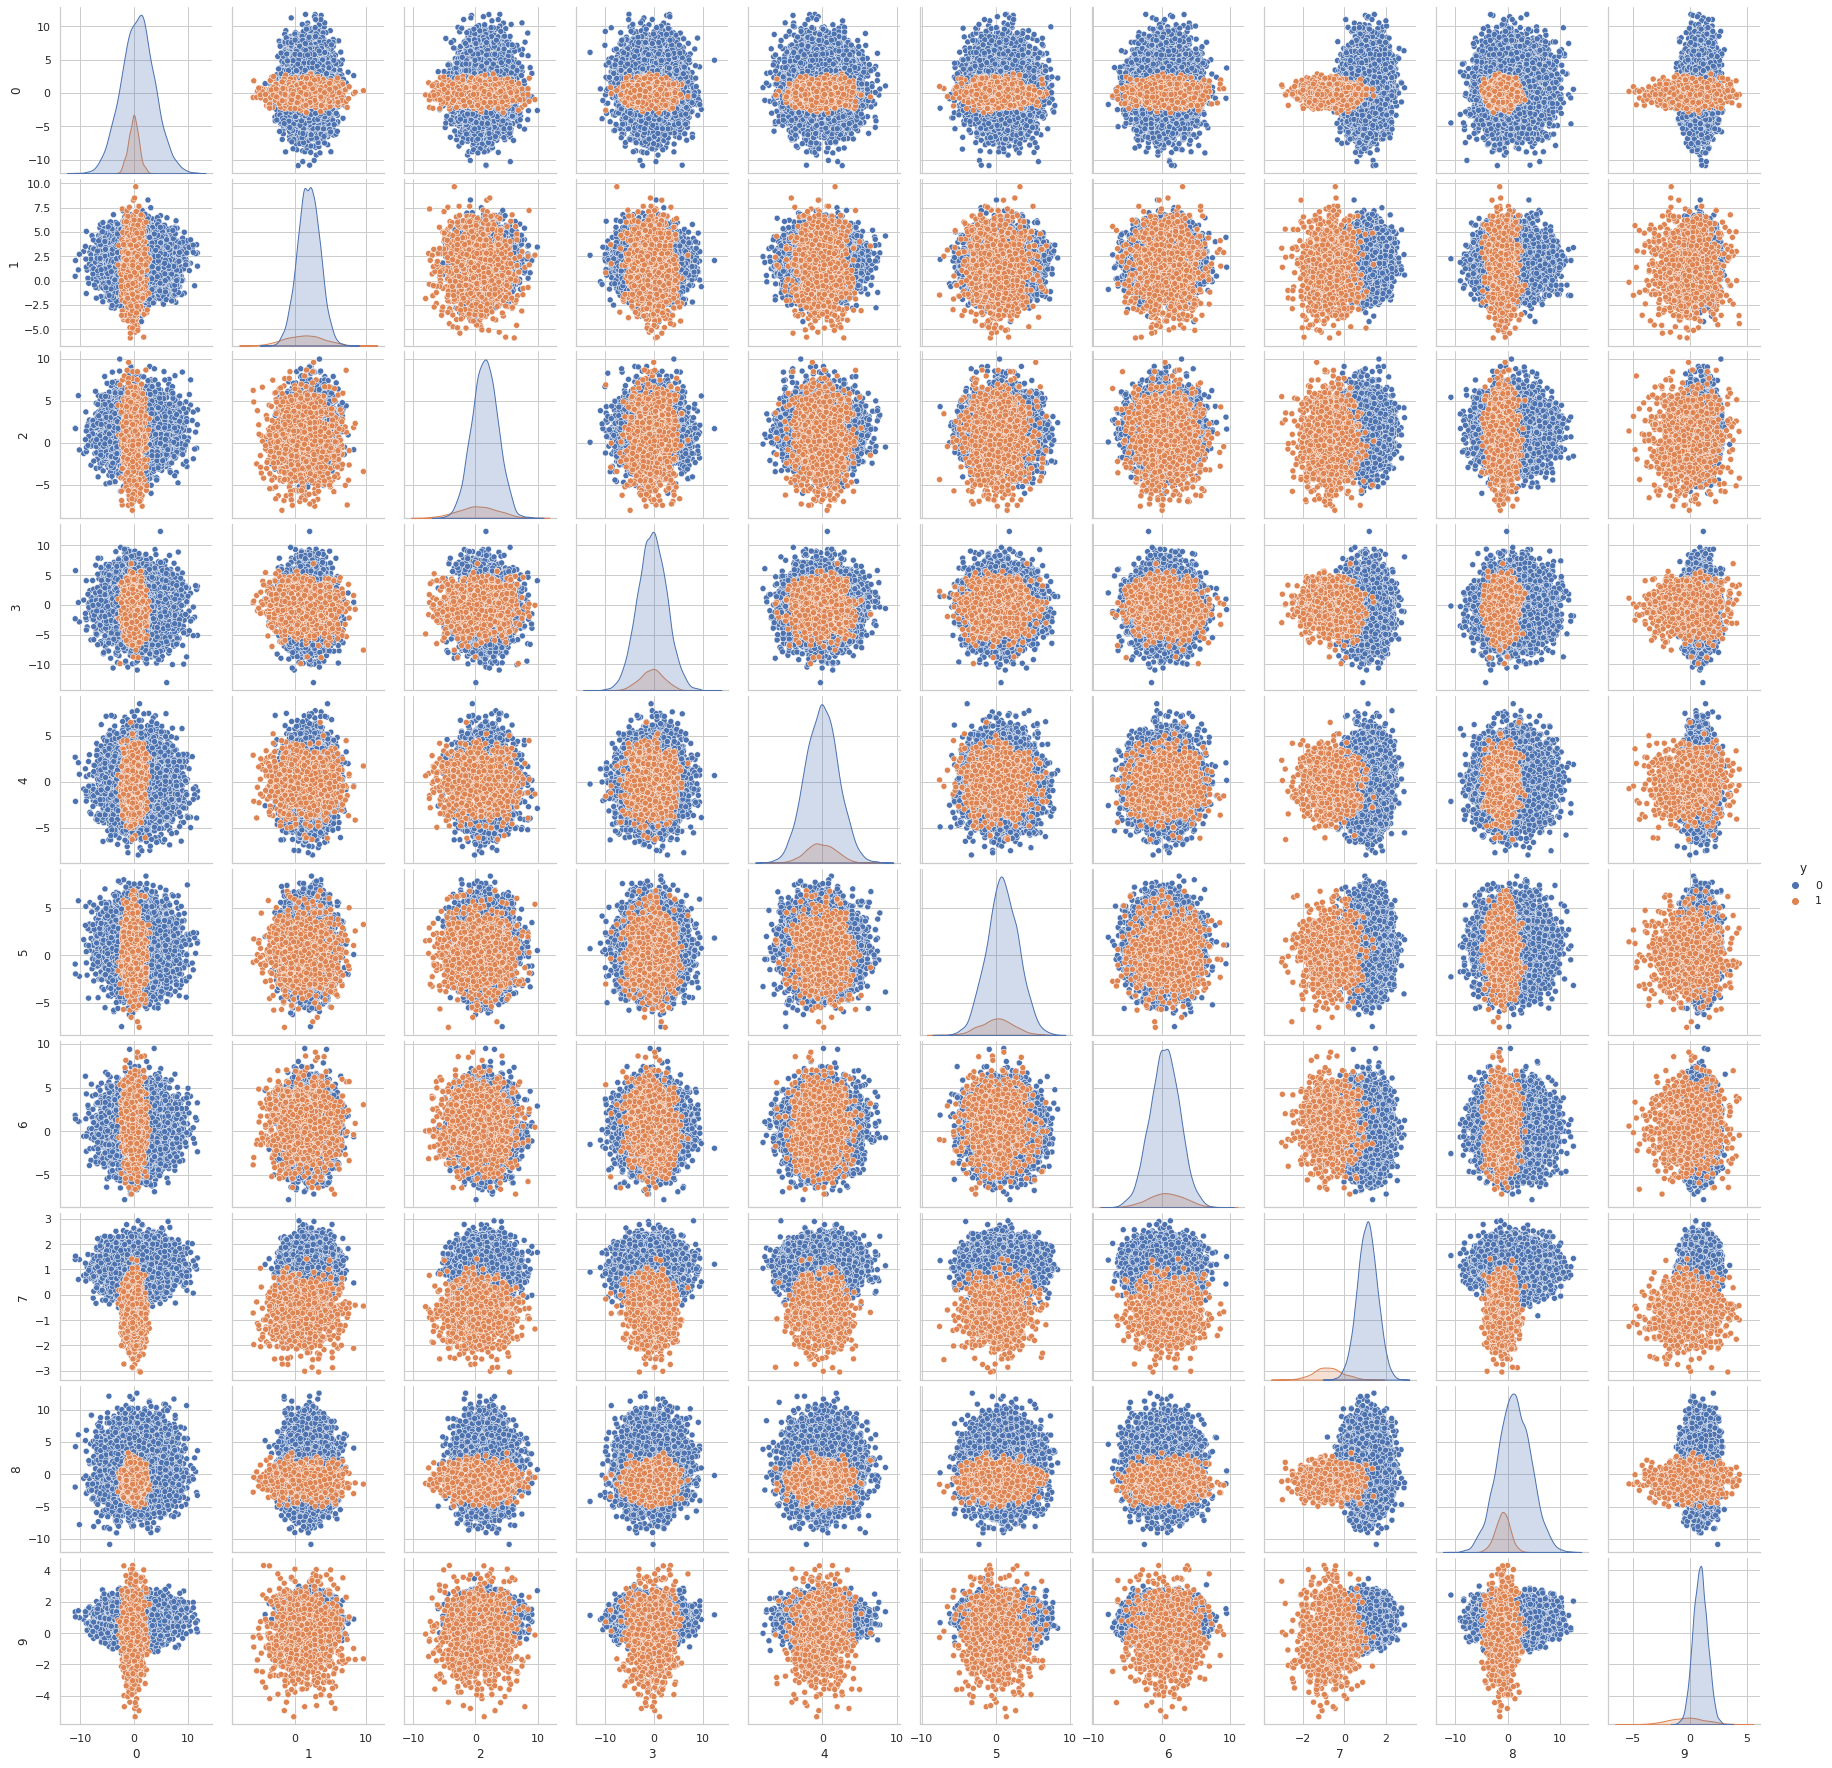

In [178]:
train = pd.concat([x_train,train_y], axis=1)
test = pd.concat([x_test,test_y], axis=1)
sns.pairplot(train, hue = 'y')

1    9000
0    9000
dtype: int64

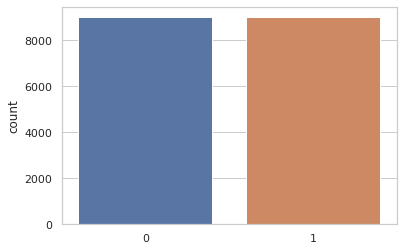

In [190]:
#use smote to deal with unbalanced data --oversample using knn style 

x_smote, y_smote = SMOTE(random_state=2021).fit_resample(x_train, train_y)
sns.countplot(y_smote)
pd.DataFrame(y_smote).value_counts()

0    9000
1    8908
dtype: int64

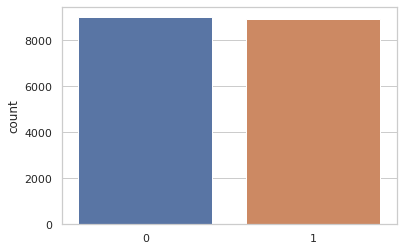

In [191]:
#use adasyn for oversample (similar with smote)
 
x_adasyn, y_adasyn = ADASYN(sampling_strategy={0:9000, 1:9000}, random_state= 2021).fit_resample(x_train, train_y)
sns.countplot(y_adasyn)
pd.DataFrame(y_adasyn).value_counts()

In [192]:
#split the train data into train/val
def split(x,y):
  x, xval,y, yval = train_test_split(
    x, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=2021,
    stratify = y
  )
  print(x.shape)
  print(xval.shape)
  return x,y,xval,yval

x,y,xval,yval = split(x_train, train_y)
smotex,smotey,smotexval,smoteyval = split(x_smote, y_smote)
adax,aday,adaxval,adayval = split(x_adasyn, y_adasyn)

(8000, 10)
(2000, 10)
(14400, 10)
(3600, 10)
(14326, 10)
(3582, 10)


In [193]:
#use random forest on each data using pipeline  
def fit(x,y, xtest, ytest):
  gp=Pipeline([ 
    ('scale', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
    ])

  clf = gp.fit(x, y)
  print('accuracy score')
  print(accuracy_score(ytest, clf.predict(xtest)))


  print('recall score')
  print(recall_score(ytest, clf.predict(xtest)))


  print('precision score')
  print(precision_score(ytest, clf.predict(xtest)))

  print('f1 score')
  print(f1_score(ytest, clf.predict(xtest)))

print('<org data>')
fit(x,y,xval,yval)
print('')
print('<smote data>')
fit(smotex,smotey,smotexval,smoteyval)
print('')
print('<adasyn data>')
fit(adax,aday,adaxval,adayval) #use smote for classification  -- f1score 

<org data>
accuracy score
0.9825
recall score
0.865
precision score
0.9558011049723757
f1 score
0.9081364829396326

<smote data>
accuracy score
0.9747222222222223
recall score
0.9705555555555555
precision score
0.9787114845938375
f1 score
0.9746164574616457

<adasyn data>
accuracy score
0.9653824678950307
recall score
0.9562289562289562
precision score
0.9737142857142858
f1 score
0.9648924122310305


In [195]:
#use pipeline and Grid Search on smote  

gp=Pipeline([ 
    ('scale', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
    ])

param = {'classify': [ 
                      SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
                      svm.SVC(kernel='linear'),
                      LogisticRegression(solver= 'sag') , 
                      RidgeClassifier(), 
                      RandomForestClassifier(random_state=2021)]} 

grid_search = GridSearchCV(gp, 
                           param, 
                           cv=3,
                           n_jobs=-1,
                           scoring='f1_micro',
                           verbose=1,
                           return_train_score=True)
 
classif = grid_search.fit(smotex,smotey)

print(classif.best_estimator_)
print(classif.best_score_)
print(classif.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    7.2s finished


Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classify',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=2021,
                                        verbose=0, warm_start=False))],
         verbose=False)
0.989722222222222

In [197]:
param_grid = {'classify__max_depth': [1, 3, 5, 10, 15], 
              'classify__n_estimators': [50, 100, 200, 500, 1000]}

gp=Pipeline([ 
    ('scale', StandardScaler()),
    ('classify', RandomForestClassifier(random_state=2021))
    ])


grid_search = GridSearchCV(gp, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='f1_micro',
                           verbose=1,
                           return_train_score=True)


final = grid_search.fit(smotex,smotey)

print(final.best_estimator_)
print(final.best_score_)
print(final.best_params_) 

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  5.3min finished


Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classify',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=15, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=None,
                                        oob_score=False, random_state=2021,
                                        verbose=0, warm_start=False))],
         verbose=False)
0.9897916666666667


In [198]:
 
print('val accuracy score')
print(accuracy_score(smoteyval, final.predict(smotexval)))

print('val recall score')
print(recall_score(smoteyval, final.predict(smotexval)))


print('val precision score')
print(precision_score(smoteyval, final.predict(smotexval)))

print('val f1 score')
print(f1_score(smoteyval, final.predict(smotexval)))

accuracy score
0.9925
recall score
0.9922222222222222
precision score
0.9927737632017788
f1 score
0.9924979160878021


In [199]:
#now use total data of smote to predict test data 
def model(x,y,xtest,ytest):
  clf = grid_res.best_estimator_
  clf = gp.fit(x, y)
  print('test accuracy score')
  print(accuracy_score(ytest, clf.predict(xtest)))


  print('test recall score')
  print(recall_score(ytest, clf.predict(xtest)))


  print('test precision score')
  print(precision_score(ytest, clf.predict(xtest)))

  print('test f1 score')
  print(f1_score(ytest, clf.predict(xtest)))

  pred = clf.predict(xtest)
  return pred, clf 


y_pred, clf = model(x_smote, y_smote,x_test,test_y)

accuracy score
0.97075
recall score
0.949
precision score
0.9921589127025614
f1 score
0.9700996677740864


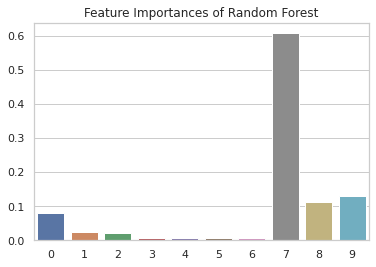

In [200]:
#random forest feature importance check 
imp = pd.Series(clf[1].feature_importances_ , index = x_train.columns)  
ftrsort = imp.sort_values(ascending=False) 
 

plt.title('Feature Importances of Random Forest')
sns.barplot(y=ftrsort, x=ftrsort.index)
plt.show()


In [210]:
#save y pred 
pd.DataFrame(y_pred).to_csv('output_test.csv', index=False)
y_pred= y_pred.transpose()  

#original shape 
pd.DataFrame(y_pred).transpose().to_csv('output_test2.csv', index=False)